In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Loading model parameters
MODULE_HANDLE = "https://tfhub.dev/google/remote_sensing/uc_merced-resnet50/1"
IMAGE_SIZE = (256, 256)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 

In [ ]:
#loading training data
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/MVNMv4_ jpg.zip" .
!unzip "/content/MVNMv4_ jpg.zip"

In [ ]:
#setting up file strucutre
!mkdir images
!mkdir images/mangrove
!mkdir images/nonmangrove 
!mv mangrove/* images/mangrove/
!mv nonmangrove/* images/nonmangrove/

In [ ]:

data_dir = '/content/images/'

#arguments for datageneration and flow
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

#setting up keras data generators
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      brightness_range=[0.6,1.0],rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/remote_sensing/uc_merced-resnet50/1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history


Epoch 1/10
1228/1228 [==============================] - 195s 159ms/step - loss: 0.2637 - accuracy: 0.9760 - val_loss: 0.3103 - val_accuracy: 0.9384
Epoch 2/10
1228/1228 [==============================] - 192s 156ms/step - loss: 0.2618 - accuracy: 0.9773 - val_loss: 0.3113 - val_accuracy: 0.9362
Epoch 3/10
1228/1228 [==============================] - 192s 156ms/step - loss: 0.2628 - accuracy: 0.9767 - val_loss: 0.3746 - val_accuracy: 0.9074
Epoch 4/10
1228/1228 [==============================] - 192s 156ms/step - loss: 0.2639 - accuracy: 0.9759 - val_loss: 0.3328 - val_accuracy: 0.9275
Epoch 5/10
1228/1228 [==============================] - 191s 156ms/step - loss: 0.2629 - accuracy: 0.9761 - val_loss: 0.3180 - val_accuracy: 0.9362
Epoch 6/10
1228/1228 [==============================] - 191s 156ms/step - loss: 0.2641 - accuracy: 0.9755 - val_loss: 0.3078 - val_accuracy: 0.9398
Epoch 7/10
1228/1228 [==============================] - 193s 157ms/step - loss: 0.2629 - accuracy: 0.9769 - val_

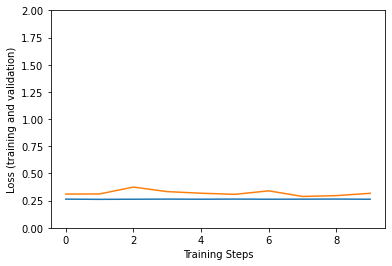

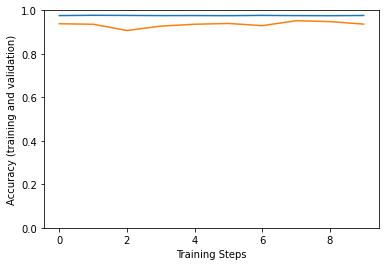

In [ ]:

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
saved_model_path = "mvnmv4_merced"
model.save(saved_model_path)
!zip -r mvnmv4_merced_bright.zip mvnmv4_merced/

INFO:tensorflow:Assets written to: mvnmv4_merced/assets


INFO:tensorflow:Assets written to: mvnmv4_merced/assets


updating: mvnmv4_merced/ (stored 0%)
updating: mvnmv4_merced/assets/ (stored 0%)
updating: mvnmv4_merced/variables/ (stored 0%)
updating: mvnmv4_merced/variables/variables.index (deflated 82%)
updating: mvnmv4_merced/variables/variables.data-00001-of-00002 (deflated 7%)
updating: mvnmv4_merced/variables/variables.data-00000-of-00002 (deflated 90%)
updating: mvnmv4_merced/saved_model.pb (deflated 91%)


In [ ]:
!cp "mvnmv4_merced_bright.zip" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Models/mvnmv4_merced_bright.zip"
